In [1]:
# %pip install rasterio pyproj transformers scikit-learn seaborn pandas

In [1]:
%cd .. 

from mast3r.model import AsymmetricMASt3R
from mast3r.fast_nn import fast_reciprocal_NNs
import mast3r.utils.path_to_dust3r
from dust3r.inference import inference
from dust3r.utils.image import load_images
from dust3r.utils.image import preprocess_images

from fast3r.dust3r.utils.image import fast_load_images
from fast3r.dust3r.inference_multiview import inference
from fast3r.models.fast3r import Fast3R

%cd localization

/Users/lucastefannicolae/Developer/AI/CV/mast3r
Warning, cannot find cuda-compiled version of RoPE2D, using a slow pytorch version instead


/opt/anaconda3/envs/mast3r/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Warning, cannot find cuda-compiled version of RoPE2D, using a slow pytorch version instead
/Users/lucastefannicolae/Developer/AI/CV/mast3r/localization


In [2]:
import torchvision.transforms.v2 as transforms
import cv2 as cv2
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import rasterio
from pyproj import Transformer
from PIL import Image
from PIL.ExifTags import TAGS 
import time
from sklearn import datasets, linear_model
import copy
import seaborn as sns
import pandas as pd
import torch
import random

from mast3r_pipeline import Mast3rPipeline
from fast3r_pipeline import Fast3rPipeline

from loc_utils import Position, Matches, LocOutput, Patches, Map_Info, CameraSpecs, DroneState

In [3]:
data_dir = '/Users/lucastefannicolae/Developer/AI/Data'  #'C:/Users/Luca Stefan/Desktop/Data'

#Centrul de jos din poza pentru Baltei si centrul centru pentru Finland

maps_dict = {
    'Balteni January' : Map_Info(
        map_gsd = 0.050005,
        patch_size = 200.0, #150 #meters
        meters_lat_degree = 111126,
        meters_lon_degree = 79232,
        map_pos = (26.03383821, 44.71866856),
        alt_offset = 104.0,
        csv_path = f'{data_dir}/Mapping Balteni/11.1.2025/balteni_january_session.csv',
        map_img = f'{data_dir}/Mapping Balteni/11.1.2025/odm_orthophoto.PNG',
        map_tif = f'{data_dir}/Mapping Balteni/11.1.2025/odm_orthophoto.tif',
        ground_imgs = f'{data_dir}/Mapping Balteni/11.1.2025/Ground images',
        satellite_imgs = f'{data_dir}/Mapping Balteni/11.1.2025/Satellite images',
        camera_specs = CameraSpecs(
                        hfov = 84.0,
                        vfov = 63.0,
                        width = 5280,
                        height = 3956,
                    ),
    ),
    'Balteni March 14' : Map_Info(
        map_gsd = 0.050012,
        patch_size = 130,# 340.0, #meters
        meters_lat_degree = 111126,
        meters_lon_degree = 79221,
        map_pos = (26.01440938, 44.7265453),
        alt_offset = 104.0,
        map_img = f'{data_dir}/Mapping Balteni/14.3.2025/DJ179-3-14-2025-orthophoto.png',
        map_tif = f'{data_dir}/Mapping Balteni/14.3.2025/DJ179-3-14-2025-orthophoto.tif',
        ground_imgs = f'{data_dir}/Mapping Balteni/14.3.2025/Ground images',
        satellite_imgs = f'{data_dir}/Mapping Balteni/14.3.2025/Satellite images',
        camera_specs = CameraSpecs(
                        hfov = 84.0,
                        vfov = 63.0,
                        width = 5280,
                        height = 3956,
                    ),
    ),
    'Finland session 2' : Map_Info(
        map_gsd = 0.173,
        patch_size = 200.0, #meters
        meters_lat_degree = 111419,
        meters_lon_degree = 55119,
        map_pos = (22.464469, 60.403669),
        alt_offset = 32.0,
        csv_path = f'{data_dir}/WIldnav_UAV_Photographs/matrice_300_session_2/matrice_session_2.csv',
        map_img = f'{data_dir}/WIldnav_UAV_Photographs/matrice_300_session_2/map_overview.jpg',
        ground_imgs = f'{data_dir}/WIldnav_UAV_Photographs/matrice_300_session_2/Ground images',
        camera_specs = CameraSpecs(
                        hfov = 84.0,
                        vfov = 63.0,
                        width = 5280,
                        height = 3956,
                    ),
    ),
    'Finland session 1' : Map_Info(
        map_gsd = 0.173,
        patch_size = 200.0, #meters
        meters_lat_degree = 111419,
        meters_lon_degree = 55119,
        map_pos = (22.464469, 60.403669),
        alt_offset = 32.0,
        csv_path = f'{data_dir}/WIldnav_UAV_Photographs/matrice_300_session_1/matrice_session_1.csv',
        map_img = f'{data_dir}/WIldnav_UAV_Photographs/matrice_300_session_1/map_overview.jpg',
        ground_imgs = f'{data_dir}/WIldnav_UAV_Photographs/matrice_300_session_1/Ground images',
        camera_specs = CameraSpecs(
                        hfov = 84.0,
                        vfov = 63.0,
                        width = 5280,
                        height = 3956,
                    ),
    )
}

map_info = maps_dict['Finland session 1']

In [4]:
colors = [
  [0, 0, 255], [0, 255, 0], [255, 0, 0], [0, 255, 255], [255, 255, 0],
  [255, 0, 255], [0, 0, 0], [255, 255, 255], [128, 128, 128], [0, 165, 255],
  [203, 192, 255], [128, 0, 128], [42, 42, 165], [0, 255, 0], [130, 0, 75],
  [238, 130, 238], [0, 215, 255], [192, 192, 192], [220, 245, 245], [128, 128, 0],
  [0, 128, 128], [0, 0, 128], [208, 224, 64], [144, 238, 144], [180, 105, 255],
  [50, 205, 154], [127, 255, 212], [250, 206, 135], [221, 160, 221], [60, 20, 220]
]

In [5]:
loc_pipeline = Mast3rPipeline(map_info=map_info,device='mps')

In [6]:
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

loc_pipeline = Fast3rPipeline(map_info=map_info,device=torch.device('mps'))

# Video localization

In [8]:
cap = cv2.VideoCapture('/Users/lucastefannicolae/Developer/AI/Data/Mapping Balteni/14.3.2025/DJI_20250314180206_0005_D.MP4')

frames = []

for id in range(20000):
    ret, frame = cap.read()

    if ret == False:
       break
       
    frame = cv2.resize(frame, (640, 360)) 
    frames.append(frame)
    
    
cap.release()

In [9]:
map_img = read_img(map_info.map_img)
satellite_data = load_satellite_transform(map_info.map_tif)

patch_size  = 130
patches = get_map_patches(map_img=map_img,map_pos=map_pos)

prev_pos = np.array([26.0161408 , 44.72698244])

locations = []

for id in range(800,2200,15):
    frame = frames[id]

    try:
        ground_img = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        loc_output, patch, center = patch_localization(patches=patches,prev_pos=prev_pos,
                                                        ground_img=ground_img,points=100,process_size=224)
        
        #display_position(loc_output,patch,ground_img,colors)

        prev_pos = loc_output.position.absolute

        locations.append([loc_output.position.absolute,loc_output.position.relative,loc_output.position.heading])
    
    except Exception as e:
        print(e)


NameError: name 'read_img' is not defined

In [ ]:
plt.imshow(map_img)

xs = []
ys = []

for loc in locations:
    w,h = map_img.shape[1], map_img.shape[0]
    x,y = absolute_to_relative(w,h,loc[0],map_pos)

    if (x >=0 and x < w) and (y>=0 and y<h):
        xs.append(x)
        ys.append(y)
plt.plot(xs, ys)

# Testing on images

Resolution change: 455x366 --> 224x224
Resolution change: 1600x1199 --> 224x224
 (Found 2 images)


/Users/lucastefannicolae/Developer/AI/CV/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):


training elapsed time was 0.0 hours,  0.0 minutes, 0.47 seconds)


/Users/lucastefannicolae/Developer/AI/CV/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/Users/lucastefannicolae/Developer/AI/CV/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


training elapsed time was 0.0 hours,  0.0 minutes, 0.11 seconds)


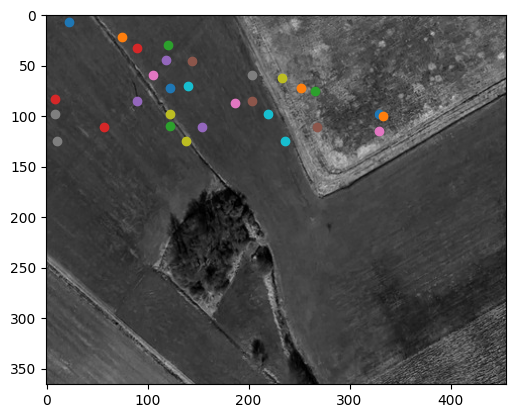

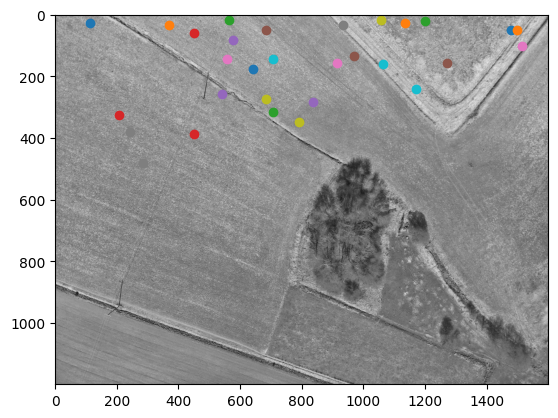

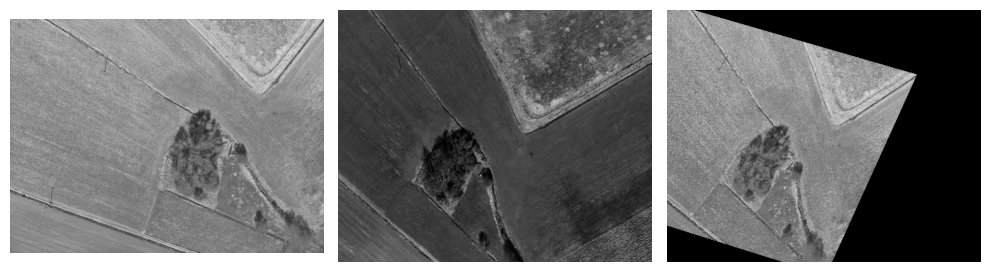

In [6]:
ground  = 'data/WhatsApp Image 2025-04-10 at 12.05.34-2.jpeg'#/Users/lucastefannicolae/Developer/AI/Data/Mapping Balteni/11.1.2025/Ground images/DJI_20250111225228_0117_D.JPG'
satellite = 'data/WhatsApp Image 2025-04-10 at 12.05.34.jpeg'#'/Users/lucastefannicolae/Developer/AI/Data/Mapping Balteni/11.1.2025/Satellite images/DJI_20250111224532_0098_D.JPG'


img1 = loc_pipeline.read_img(satellite)
img2 = loc_pipeline.read_img(ground)

start_time = time.time()

input_data = [[img1, img1.shape[::-1][1:]],
                  [img2, img2.shape[::-1][1:]]]
new_imgs, new_res = loc_pipeline.load_processed_images(input_data,224)

loc_pipeline.output_duration(start_time)

start_time = time.time()
with torch.no_grad():
    matches, total_matches = loc_pipeline.predict_features(new_imgs,100)

loc_pipeline.output_duration(start_time)

for id in range(len(matches)):
    matches[id] = loc_pipeline.resize_matches(matches[id],new_res[id],input_data[id][1])

H = loc_pipeline.get_h_matrix(matches[1],matches[0],method=cv2.RANSAC)



plt.imshow(Image.fromarray(img1))
for i in range(min(30,len(matches[0]))):
    x0, y0 = matches[0][i]
    plt.scatter(x0, y0)
plt.show()

plt.imshow(Image.fromarray(img2))
for i in range(min(30,len(matches[1]))):
    x0, y0 = matches[1][i]
    plt.scatter(x0, y0)
plt.show()


height, width, _ = img1.shape
img_aligned = cv2.warpPerspective(img2, H, (width, height))

rows, cols = (1,3)
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
for ax, img in zip(axes.flat, [img2,img1,img_aligned]):
    img_rgb = img
    ax.imshow(img_rgb)
    ax.axis('off') 
plt.tight_layout()
plt.show()

# Image visual localization

In [6]:
session_data = []
list = glob.glob(os.path.join(map_info.ground_imgs, '*'))
list.sort()

for path in list:
    rlon, rlat, alt = loc_pipeline.filter_gps_data(path)
    session_data.append({
        'Filename': path.split('/')[-1],
        'Latitude': rlat,
        'Longitude': rlon,
        'Altitude': alt,
        'Gimball_Roll':0.0,
        'Gimball_Yaw':0.0,
        'Gimball_Pitch':0.0,
        'Flight_Roll':0.0,
        'Flight_Yaw': 0.0,
        'Flight_Pitch': -10,
    })

session_data_csv = pd.DataFrame(session_data)
session_data_csv.to_csv('balteni_january_session.csv',index=False)
session_data_csv.head(5)

,Filename,Latitude,Longitude,Altitude,Gimball_Roll,Gimball_Yaw,Gimball_Pitch,Flight_Roll,Flight_Yaw,Flight_Pitch
0,DJI_20250111225134_0108_D.JPG,44.717991,26.034447,111.217,0.0,0.0,0.0,0.0,0.0,-10
1,DJI_20250111225159_0109_D.JPG,44.718005,26.034377,111.217,0.0,0.0,0.0,0.0,0.0,-10
2,DJI_20250111225203_0110_D.JPG,44.718065,26.034341,111.217,0.0,0.0,0.0,0.0,0.0,-10
3,DJI_20250111225207_0111_D.JPG,44.718124,26.034305,111.217,0.0,0.0,0.0,0.0,0.0,-10
4,DJI_20250111225210_0112_D.JPG,44.718176,26.034271,111.217,0.0,0.0,0.0,0.0,0.0,-10


In [24]:
%pip install exif

Note: you may need to restart the kernel to use updated packages.


In [6]:
session_csv = pd.read_csv(map_info.csv_path)

map_img = loc_pipeline.read_img(map_info.map_img)
map_img = loc_pipeline.img_to_grayrgb(map_img)

patches = loc_pipeline.get_map_patches(map_img=map_img)

r_loc = []
p_loc = []

lon_errors = []
lat_errors = []
frontal_errors = []
lateral_errors = []
distance_errors = []

prev_pos = None

for id in range(30,60):
    try:
        row = session_csv.iloc[id]
        if prev_pos == None:
            prev_pos = np.array([row['Longitude'],row['Latitude']])

        ground_img = loc_pipeline.read_img('/'.join(map_info.map_img.split('/')[::-1][1:][::-1])+'/Ground Images/'+row['Filename'])
        ground_img = loc_pipeline.img_to_grayrgb(ground_img)

        start_time = time.time()

        #rlon, rlat, alt = row['Longitude'], row['Latitude'], row['Altitude']
        rlon, rlat, alt = loc_pipeline.filter_gps_data(
                                            '/'.join(map_info.map_img.split('/')[::-1][1:][::-1]) +
                                            '/Ground Images/' + 
                                            row['Filename']
                                        )
        alt -= map_info.alt_offset
        drone_state = DroneState(
                            alt = alt,
                            pitch = np.deg2rad(row['Flight_Pitch']+row['Gimball_Pitch']),
                            roll = np.deg2rad(0.0),
                        )

        loc_pipeline.point_cloud_conf_coef = 0.4
        loc_pipeline.point_cloud_dist_coef = 15

        with torch.no_grad():
            loc_output, patch, center = loc_pipeline.patch_localization(
                                                            patches=patches,
                                                            prev_pos=prev_pos,
                                                            ground_img=ground_img,
                                                            points=100,
                                                            process_size=224,
                                                            camera_specs=map_info.camera_specs,
                                                            drone_state = drone_state
                                                        )
        loc_pipeline.output_duration(start_time)

        
        plon, plat = loc_output.position.absolute[0], loc_output.position.absolute[1]

        if False:
            loc_pipeline.display_position(loc_output,patch,ground_img,colors)

            height, width, _ = patch.shape
            img_aligned = cv2.warpPerspective(ground_img, loc_output.matches.h_matrix, (width, height))
            plt.imshow(img_aligned)
            plt.show()

        
        print(f'Alt: {alt},  Lon: {plon},  Lat: {plat}, Heading: {loc_output.position.heading}')

        ptranslated_pos = np.array([plon * loc_pipeline.meters_lon_degree,
                       plat * loc_pipeline.meters_lat_degree])
        translated_pos = np.array([rlon * loc_pipeline.meters_lon_degree,
                       rlat * loc_pipeline.meters_lat_degree])
        

        lat_dif = np.abs(ptranslated_pos[1] - translated_pos[1])
        lon_dif = np.abs(ptranslated_pos[0] - translated_pos[0])

        dist = np.sqrt(lat_dif**2 + lon_dif**2)
        alpha = np.abs(loc_output.position.heading - np.pi/2 - np.arctan2(lon_dif,lat_dif))
        
        front_dif = np.cos(alpha) * dist
        lateral_dif = np.sin(alpha) * dist

        lon_errors.append(np.abs(plon-rlon))
        lat_errors.append(np.abs(plat-rlat))
        frontal_errors.append(front_dif)
        lateral_errors.append(lateral_dif)
        distance_errors.append(dist)

        r_loc.append(np.array([rlon,rlat]))
        p_loc.append(np.array([plon,plat]))

        prev_pos = loc_output.position.absolute

    except Exception as e:
        print(e)



Resolution change: 1156x1156 --> 224x224
Resolution change: 4056x3040 --> 224x224
 (Found 2 images)


/Users/lucastefannicolae/Developer/AI/CV/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/Users/lucastefannicolae/Developer/AI/CV/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/Users/lucastefannicolae/Developer/AI/CV/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


training elapsed time was 0.0 hours,  0.0 minutes, 1.10 seconds)
Alt: 26.654000000000003,  Lon: 22.462599600031965,  Lat: 60.40223616262695, Heading: 1.172317899912933
Resolution change: 1156x1156 --> 224x224
Resolution change: 4056x3040 --> 224x224
 (Found 2 images)
training elapsed time was 0.0 hours,  0.0 minutes, 0.39 seconds)
Alt: 26.714,  Lon: 22.462534918339387,  Lat: 60.40227899727267, Heading: 1.1740996220150488
Resolution change: 1156x1156 --> 224x224
Resolution change: 4056x3040 --> 224x224
 (Found 2 images)
training elapsed time was 0.0 hours,  0.0 minutes, 0.35 seconds)
Alt: 26.645000000000003,  Lon: 22.46246397722551,  Lat: 60.402263010704644, Heading: 1.2233732012712277
Resolution change: 1156x1156 --> 224x224
Resolution change: 4056x3040 --> 224x224
 (Found 2 images)
training elapsed time was 0.0 hours,  0.0 minutes, 0.38 seconds)
Alt: 26.619999999999997,  Lon: 22.46230496861444,  Lat: 60.40229177448945, Heading: 1.1576148783467128
Resolution change: 1156x1156 --> 224x2

In [ ]:
list = glob.glob(os.path.join(map_info.ground_imgs, '*'))
list.sort()

alt_offset = 104.0
map_img = loc_pipeline.read_img(map_info.map_img)
map_img = loc_pipeline.img_to_grayrgb(map_img)


patches = loc_pipeline.get_map_patches(map_img=map_img)

list = list[70:75]
prev_pos = loc_pipeline.filter_gps_data(list[0])[:2]# (22.4632222,60.40221388888889) #(22.4632222,60.40221388888889)#(22.46267, 60.40231)


r_loc = []
p_loc = []

lon_errors = []
lat_errors = []
frontal_errors = []
lateral_errors = []
distance_errors = []

for path in list:
    try:
        ground_img = loc_pipeline.read_img(path)#[1000:,:]
        ground_img = loc_pipeline.img_to_grayrgb(ground_img)

        # patch, center = loc_pipeline.get_closest_patch(patches=patches,prev_pos=prev_pos)
        # break

        start_time = time.time()

        rlon, rlat, alt = loc_pipeline.filter_gps_data(path)
        alt -= alt_offset
        drone_state = DroneState(
                            alt = alt,
                            pitch = np.deg2rad(-85), # from horizon to the ground (85 - finland)
                            roll = np.deg2rad(0.0),
                        )

        loc_pipeline.point_cloud_conf_coef = 0.4
        loc_pipeline.point_cloud_dist_coef = 15

        with torch.no_grad():
            loc_output, patch, center = loc_pipeline.patch_localization(
                                                            patches=patches,
                                                            prev_pos=prev_pos,
                                                            ground_img=ground_img,
                                                            points=100,
                                                            process_size=224,
                                                            camera_specs=map_info.camera_specs,
                                                            drone_state = drone_state
                                                        )
        loc_pipeline.output_duration(start_time)

        
        plon, plat = loc_output.position.absolute[0], loc_output.position.absolute[1]

        if False:
            loc_pipeline.display_position(loc_output,patch,ground_img,colors)

            height, width, _ = patch.shape
            img_aligned = cv2.warpPerspective(ground_img, loc_output.matches.h_matrix, (width, height))
            plt.imshow(img_aligned)
            plt.show()

        
        print(f'Alt: {alt},  Lon: {plon},  Lat: {plat}, Heading: {loc_output.position.heading}')

        ptranslated_pos = np.array([plon * loc_pipeline.meters_lon_degree,
                       plat * loc_pipeline.meters_lat_degree])
        translated_pos = np.array([rlon * loc_pipeline.meters_lon_degree,
                       rlat * loc_pipeline.meters_lat_degree])
        

        lat_dif = np.abs(ptranslated_pos[1] - translated_pos[1])
        lon_dif = np.abs(ptranslated_pos[0] - translated_pos[0])

        dist = np.sqrt(lat_dif**2 + lon_dif**2)
        alpha = np.abs(loc_output.position.heading - np.pi/2 - np.arctan2(lon_dif,lat_dif))
        
        front_dif = np.cos(alpha) * dist
        lateral_dif = np.sin(alpha) * dist

        lon_errors.append(np.abs(plon-rlon))
        lat_errors.append(np.abs(plat-rlat))
        frontal_errors.append(front_dif)
        lateral_errors.append(lateral_dif)
        distance_errors.append(dist)

        r_loc.append(np.array([rlon,rlat]))
        p_loc.append(np.array([plon,plat]))

        prev_pos = loc_output.position.absolute

    except Exception as e:
        print(e)


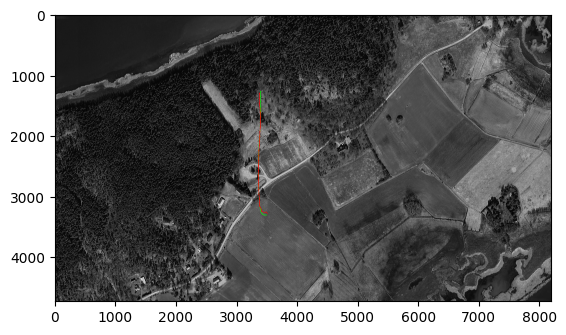

In [7]:
def draw_trajectory(
    image: np.ndarray,
    points: np.ndarray,
    color: tuple = (0, 255, 0),
    thickness: int = 8,
    arrow_tip_length: float = 0.1
) -> np.ndarray:
    output = image.copy()

    if len(points) < 2:
        return output

    for i in range(len(points) - 1):
        start = tuple(points[i].astype(int))
        end = tuple(points[i + 1].astype(int))
        cv2.arrowedLine(
            output,
            start,
            end,
            color,
            thickness,
            cv2.LINE_AA,
            tipLength=arrow_tip_length
        )
    return output


result = draw_trajectory(map_img, 
                        [ 
                            np.array(loc_pipeline.absolute_to_relative(map_img.shape[1],map_img.shape[0],loc,loc_pipeline.map_pos)) 
                            for loc in r_loc
                        ])
result = draw_trajectory(result, 
                        [ 
                            np.array(loc_pipeline.absolute_to_relative(map_img.shape[1],map_img.shape[0],loc,loc_pipeline.map_pos)) 
                            for loc in p_loc
                        ],
                        color=(255,0,0)
                        )#[1000:3500,2500:4000]
plt.imshow(result)

In [30]:
cv2.imwrite('/Users/lucastefannicolae/Developer/AI/CV/mast3r/localization/data/output/compare.png',
            cv2.cvtColor(cv2.resize(result,(result.shape[1]//4,result.shape[0]//4)),
                         cv2.COLOR_BGR2RGB)) 

True

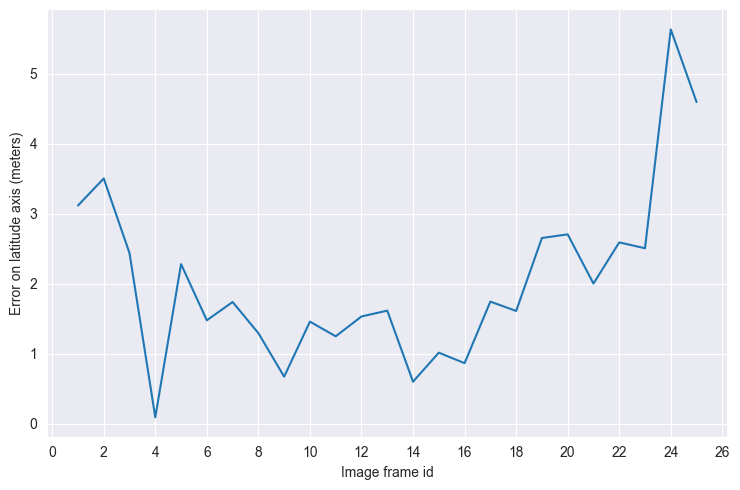

In [22]:
from matplotlib.ticker import MultipleLocator

xlabel = 'Image frame id'
ylabel = 'Error on latitude axis (meters)'
data = {xlabel: np.arange(len(lat_errors)-5)+1,
        ylabel: np.array(lat_errors[3:][:-2])*map_info.meters_lat_degree}

sns.set_style("darkgrid")

g = sns.relplot(
    data=data,
    x=xlabel,
    y=ylabel,
    kind="line",
    aspect=1.5
)

for ax in g.axes.flat:
    ax.xaxis.set_major_locator(MultipleLocator(2))
    ax.yaxis.set_major_locator(MultipleLocator(1))

plt.tight_layout()
plt.show()


In [53]:
distance_errors

[np.float64(4.3502611149282275),
 np.float64(10.193456353174891),
 np.float64(8.400373730828942),
 np.float64(3.5669431495685506),
 np.float64(3.9078571012235215),
 np.float64(2.6059688189219217),
 np.float64(0.10371262359970494),
 np.float64(2.379197138612301),
 np.float64(1.4800950996619155),
 np.float64(1.7694334206335662),
 np.float64(1.3208679342481742),
 np.float64(0.6799010156653525),
 np.float64(1.4926195222445628),
 np.float64(1.252331750900735),
 np.float64(1.5423238402329411),
 np.float64(1.6914740302742812),
 np.float64(0.8503369666341495),
 np.float64(1.053611463385289),
 np.float64(1.2767532718976977),
 np.float64(1.809600435703944),
 np.float64(1.6276399150145398),
 np.float64(2.6655633344542036),
 np.float64(2.713919614439154),
 np.float64(2.0059526400226817),
 np.float64(2.595273018703635),
 np.float64(2.9094070529988083),
 np.float64(5.961492950371544),
 np.float64(6.159207121473442),
 np.float64(7.020241181561817),
 np.float64(6.373647590000263)]

In [ ]:
good_ids =  np.where(np.array(distance_errors)<100)

data = pd.DataFrame({
    'Longitude':np.concatenate([np.array(r_loc)[good_ids][:,0],np.array(p_loc)[good_ids][:,0] ]),
    'Latitude':np.concatenate([np.array(r_loc)[good_ids][:,1],np.array(p_loc)[good_ids][:,1] ]),
    'Location': ['Real']*len(good_ids[0]) + ['Predicted']*len(good_ids[0])
})

sns.set_theme(style="darkgrid") 
sns.lineplot(x='Longitude', y='Latitude',marker="o", linestyle="-", hue='Location',data=data)

In [ ]:
arr = np.array([0]+distance_errors)[np.where(np.array([0]+distance_errors)<30)]

In [ ]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
ax.plot(arr,scalex=True)
plt.xticks(np.arange(1, 25, step=1))
plt.xlabel('Image id')
plt.ylabel('Localization error in meters')

plt.show()

In [ ]:
satellite_headings = np.array([108.64213312, 108.99024962, 108.63632384, 108.67893659,
       108.74653385, 109.07792512, 108.89159001, 108.79188643,
       108.96305446, 109.01209346, 108.78434108, 108.9914004 ,
       110.1273229 ]) 
satellite_headings-=90

In [ ]:
w,h = satellite_img.shape[1], satellite_img.shape[0]

(get_global_pos(w/2,0,w,h,satellite_data = satellite_data, center_loc = None)[1] -
get_global_pos(w/2,h,w,h,satellite_data = satellite_data, center_loc = None)[1]) / h * meters_lat_degree

In [ ]:
# from tqdm import tqdm
# image_pairs = glob.glob(os.path.join(f'{data_dir}/Mapping Balteni/Ground image', '*'))[1:2]

# satellite_data = load_satellite_transform('data/satellite/odm_orthophoto.tif')

# lon_errors = []
# lat_errors = []
# processed_paths = []
# total_matches = []
# matching_errors = []

# for id in range(len(image_pairs)):
#     gpath = image_pairs[id]

#     id = 0
#     for satellite_path in glob.glob(os.path.join(f'{data_dir}/Mapping Balteni/Satellite images', '*')):
#         ground_img = cv2.cvtColor(cv2.imread(gpath),cv2.COLOR_BGR2RGB)
#         satellite_img = rotate_img(cv2.cvtColor(cv2.imread(satellite_path),cv2.COLOR_BGR2RGB),satellite_headings[id])
#         slon, slat,_ = filter_gps_data(satellite_path)
#         w,h = cv2.imread(satellite_path).shape[::-1][1:]

        
#         loc_output = localize(satellite_img,None,ground_img,points=100)
#         loc, heading = loc_output['position']['loc']['image'], loc_output['position']['angle']

#         total_matches.append(loc_output['matches']['total'])

#         if False:
#             display_position(loc,heading,satellite_img,ground_img,loc_output,colors)

#         px, py = loc_output['position']['loc']['image']
#         plon = slon + (px-w/2) * 0.0138 / 79000.0
#         plat = slat + (py-h/2) * 0.0138 / 111320.0
#         rlon, rlat, alt = filter_gps_data(gpath)
#         alt -= alt_offset
        

#         plon, plat = get_corrected_pose(plon,plat,heading,alt)

#         print(f'Alt: {alt},  Lon: {plon},  Lat: {plat}')

#         lon_errors.append(np.abs(plon-rlon))
#         lat_errors.append(np.abs(plat-rlat))
#         processed_paths.append(gpath)
#         matching_errors.append(get_matching_error(loc_output,satellite_img.shape[1],satellite_img.shape[0]))
#         id+=1

Tif based localization

In [ ]:
h, w = satellite_img.shape[:2]

print(get_global_pos(w/2,h/2,w,h,satellite_data))

(get_global_pos(w/2,h/2,w,h,satellite_data)[1] - get_global_pos(w/2,h,w,h,satellite_data)[1]) * meters_lat_degree / (h/2)

In [ ]:
from tqdm import tqdm
image_pairs = glob.glob(os.path.join(map_info.ground_imgs, '*'))
image_pairs.sort()
image_pairs = image_pairs[0:10]

satellite_img = read_img(map_info.map_img)
satellite_data = load_satellite_transform(map_info.map_tif)

lon_errors = []
lat_errors = []
processed_paths = []
total_matches = []

r_loc = []
p_loc = []

for id in range(len(image_pairs)):
    gpath = image_pairs[id]
    ground_img = cv2.cvtColor(cv2.imread(gpath),cv2.COLOR_BGR2RGB)

    try:
        loc_output = localize(satellite_img,ground_img,points=150,satellite_data=satellite_data,process_size=224)
        loc, heading = loc_output.position.relative, loc_output.position.heading

        total_matches.append(loc_output.matches.total)

        if True:
            display_position(loc_output,satellite_img,ground_img,colors)

        plon, plat = loc_output.position.absolute[0], loc_output.position.absolute[1]
        rlon, rlat, alt = filter_gps_data(gpath)
        alt -= alt_offset


        plon, plat = get_corrected_pose(plon,plat,heading,alt)

        print(f'Alt: {alt},  Lon: {plon},  Lat: {plat}')

        r_loc.append(np.array([rlon,rlat]))
        p_loc.append(np.array([plon,plat]))


        lon_errors.append(np.abs(plon-rlon))
        lat_errors.append(np.abs(plat-rlat))
        processed_paths.append(gpath)
        # matching_errors.append(get_matching_error(loc_output,satellite_img.shape[1],satellite_img.shape[0]))
 
    except Exception as e:
        print(e)

In [ ]:
lat_errors = np.array(lat_errors) * meters_lat_degree
lon_errors = np.array(lon_errors) * meters_lon_degree 
distance_errors = np.sqrt(lat_errors ** 2 + lon_errors ** 2)

In [ ]:
np.mean(distance_errors)

In [ ]:

plt.plot(distance_errors)
plt.show()

In [ ]:
arr = []
for v in distance_errors:
    if v <= 30:
        arr.append(v)
np.mean(np.array(arr))

In [ ]:
for id in range(len(processed_paths)):
    if distance_errors[id] > 50:
        plt.imshow(Image.open(processed_paths[id]))
        print(distance_errors[id])
        plt.show()

In [ ]:
from transformers import pipeline
from PIL import Image

pipe = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Base-hf")


In [ ]:

image =Image.fromarray(img_aligned).resize((640,640)) #Image.open(ground_path).resize((640,640))

start_time= time.time() # set the time at which inference started

depth = pipe(image)["depth"]

output_duration(start_time)

plt.imshow(depth.resize((5000,4000)),cmap='gray')